In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import List, Dict
import string
from ast import literal_eval
from collections import Counter
import operator

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

### EDA train val df

In [2]:
DATA_PATH = os.path.join(
    "..", "..", "..", "..", "data", "frameworks_data", "data_v0.7.1"
)
experiment_name = "pl-data-v07"

kept_cols = ["excerpt", "entry_id", "target", "lang"]  # , 'analysis_framework_id']

df = (
    pd.read_csv(
        os.path.join(DATA_PATH, "new_columns_train_val_v0.7.1.csv.gz"),
        compression="gzip",
    )
    .drop_duplicates()[kept_cols]
    .copy()
)

df = df[df.lang == "en"]
df["target"] = df.target.apply(
    lambda x: [
        item
        for item in literal_eval(x)
        if "secondary" not in item and "first_level_tags->pillars" not in item
    ]
)
df.shape


(140715, 4)

In [3]:
# original function in 
# https://github.com/the-deep/deep-experiments/blob/modelling_experiments/notebooks/models/selim/data_preprocessing/data_preprocessing_dev.ipynb

def get_non_duplicates_ids(df):
    # find if there are any duplicates
    counts = df['excerpt'].value_counts().rename('en_counts')

    treated_df_with_counts = df.merge(counts.to_frame(),
                                    left_on='excerpt',
                                    right_index=True)

    non_duplicates_ids = treated_df_with_counts[treated_df_with_counts.en_counts==1].entry_id.tolist()

    return non_duplicates_ids


non_duplicates_ids = get_non_duplicates_ids(df)
df = df[df.entry_id.isin(non_duplicates_ids)].drop(columns=['lang'])
df.shape

(136446, 3)

In [4]:
def flatten(t):
    """
    flatten a list of lists.
    """
    return [item for sublist in t for item in sublist]

# excerpts contain context added manuylly from taggers, we delete the context
def delete_context(text: str) -> str:
    if text[0] == "[":
        n_strings = len(text)
        hook_end = 0
        while text[hook_end] != "]" and hook_end < 50:
            hook_end += 1
            if hook_end==(n_strings-1):
                return text

        if hook_end < 70:
            return text[(hook_end + 1) :].lstrip()
        else:
            return text.lstrip()

    else:
        return text.lstrip()

df['excerpt'] = df['excerpt'].apply(delete_context)

# For LGBTQI + to become LGBTQI+
df['excerpt'] = df['excerpt'].apply(lambda x: x.replace(' +', '+'))

In [5]:
df.target.iloc[0]

['first_level_tags->sectors->Education',
 'subpillars->Context->Socio Cultural',
 'subpillars->Capacities & Response->International Response',
 'subpillars->Capacities & Response->National Response']

In [6]:
# Extract treated kwords for each excerpt

lgbt_kw = [
    "homosex",
    "lgbt",
    "lgtb",
    "lesbian",
    "bisex",
    "transgender",
    "intersex",
    "queer",
]

sex_worker_kw = ["sex worker"]
refugee_kw = ["refugee"]
migrant_kw = ["migrant"]
venezuellian_kw = ['venezuel']

asylum_seeker_kw = ["asylum seeker", "asylum-seeker"]

female_linked_lexic_kw = ['menstr', 'pregnan', 'hygien', 'lacta']

idp_kw = [
    "idp",
    "internally-displaced",
    "internally displaced",
]

female_kw = ["women", "woman", "girl", "female", "mother"]

generic_kw_groups = {
    'female': female_kw,
    'asylum_seeker': asylum_seeker_kw,
    'idp': idp_kw,
    'sex_worker': sex_worker_kw,
    'refugee': refugee_kw,
    'migrant': migrant_kw,
    'lgbt': lgbt_kw,
    'venezuella': venezuellian_kw,
    'female_lexic': female_linked_lexic_kw
}

male_kw = ["men", "man", "male", "boy", "boys", "father", "fathers"]
female_linked_lexic = ["menstr", "pregnan", "hygien", "lacta"]

def men_kw_in_excerpt(excerpt: str) -> List[str]:
    men_kw = []
    low_excerpt = excerpt.lower()
    excerpt_words = low_excerpt.split(" ")
    for one_word in excerpt_words:
        one_word_no_punctuation = one_word.translate(
            str.maketrans("", "", string.punctuation)
        )
        men_kw += [
            one_male_kw
            for one_male_kw in male_kw
            if one_word_no_punctuation == one_male_kw
        ]

    return men_kw


def kw_in_excerpt(excerpt: str, kw_list: List[str]) -> List[str]:
    low_excerpt = excerpt.lower()
    return [one_female_kw for one_female_kw in kw_list if one_female_kw in low_excerpt]


df["male_kw"] = df.excerpt.apply(men_kw_in_excerpt)

for name, kwords in tqdm(generic_kw_groups.items()):
    df[f"{name}_kw"] = df.excerpt.apply(lambda x: kw_in_excerpt(x, kwords))


100%|██████████| 9/9 [00:06<00:00,  1.40it/s]


In [7]:
df.head(2)

,excerpt,entry_id,target,male_kw,female_kw,asylum_seeker_kw,idp_kw,sex_worker_kw,refugee_kw,migrant_kw,lgbt_kw,venezuella_kw,female_lexic_kw
0,"After past, partially implemented attempts, th...",489435.0,"[first_level_tags->sectors->Education, subpill...",[],[],[],[],[],[],[],[],[],[]
1,"Now with the lockdown planned for a week, all ...",194719.0,[subpillars->Covid-19->Restriction Measures],[],[],[],[],[],[],[],[],[],[]


In [8]:
kw_columns = [col for col in df.columns if 'kw' in col]
kw_columns

['male_kw',
 'female_kw',
 'asylum_seeker_kw',
 'idp_kw',
 'sex_worker_kw',
 'refugee_kw',
 'migrant_kw',
 'lgbt_kw',
 'venezuella_kw',
 'female_lexic_kw']

### get n entries per kw

In [9]:
def get_prop_kw(kw):
    return round(100 * df[df[one_kw_col].apply(lambda x: len(x)>0)].shape[0] / df.shape[0])

for one_kw_col in kw_columns:
    print(f'The {one_kw_col} kw is contained in {get_prop_kw(one_kw_col)} % of the train val dataset.') 

The male_kw kw is contained in 5 % of the train val dataset.
The female_kw kw is contained in 11 % of the train val dataset.
The asylum_seeker_kw kw is contained in 1 % of the train val dataset.
The idp_kw kw is contained in 6 % of the train val dataset.
The sex_worker_kw kw is contained in 0 % of the train val dataset.
The refugee_kw kw is contained in 7 % of the train val dataset.
The migrant_kw kw is contained in 6 % of the train val dataset.
The lgbt_kw kw is contained in 0 % of the train val dataset.
The venezuella_kw kw is contained in 6 % of the train val dataset.
The female_lexic_kw kw is contained in 4 % of the train val dataset.


## get barplots

In [9]:
def get_final_ratio(prop: float) -> float:
    if prop >= 1:
        return prop
    else:
        return -1 / prop


def get_tags_proportions(target: List[List[str]]) -> Dict[str, float]:
    n_entries = len(target)
    counts_per_tag = dict(Counter(flatten(target)))
    props_per_tag = {
        clean_tag_name(tag): get_final_ratio(100 * count / n_entries)
        for tag, count in counts_per_tag.items()
    }
    return props_per_tag


def clean_tag_name(tag: str) -> str:
    return "->".join(tag.split("->")[1:])


In [10]:
kw_targets = {}
targets_overall = df.target.tolist()
overall_proportions = get_tags_proportions(targets_overall)

for one_kw_col in kw_columns:
    targets_one_kw = df[df[one_kw_col].apply(lambda x: len(x)>0)].target.tolist()
    proportions = get_tags_proportions(targets_one_kw)
    ratio_kw_to_original = {tag: round(proportions[tag] / overall_proportions[tag], 1) for tag in proportions.keys()}
    kw_targets[one_kw_col] = ratio_kw_to_original


In [16]:
def get_vizu_2_lvl(tot_proportions, max_ratio: float = 1, image_name: str = None):
    """
    vizu for hierarchial tags (example: pillars->subpillars)
    """
    assert max_ratio >= 1
    min_ratio = 1 / max_ratio
    tot_proportions = {
        tag: ratio for tag, ratio in tot_proportions.items() if ratio > max_ratio
    }
    level0 = [item.split("->")[0] for item in tot_proportions.keys()]
    n_level0 = len(set(level0))

    max_prop = max(list(tot_proportions.values()))
    min_prop = min(list(tot_proportions.values()))

    unique_level1 = list(tot_proportions.keys())
    unique_level0 = [item.split("->")[0] for item in unique_level1]

    level0_counts = dict(Counter(unique_level0))

    sorted_d = dict(
        sorted(level0_counts.items(), key=operator.itemgetter(1), reverse=True)
    )
    level0_ordering = list(sorted_d.keys())

    fig, axes = plt.subplots(
        n_level0,
        1,
        sharex=False,
        figsize=(10 + n_level0, 2 + n_level0 * 1.1),
        facecolor="white",
    )

    for j in range(n_level0):
        level0_tmp = level0_ordering[j]

        proportions = {
            tag_name.split("->")[1]: tag_count
            for tag_name, tag_count in tot_proportions.items()
            if level0_tmp in tag_name
        }

        y = list(proportions.keys())
        x = list(proportions.values())

        axes[j].set_title(f"{level0_tmp}", fontsize=14)
        plt.gcf().autofmt_xdate()
        # axes[i].xaxis.set_visible(False)
        axes[j].set_xlim([0, max_prop * 1.2])
        axes[j].yaxis.set_tick_params(labelsize=11)
        # axes[i].axvline(x=0.5)
        sns.barplot(ax=axes[j], y=y, x=x, color="#0077b6").set(
            xlabel=None
        )  # colors_from_values(y, "rocket_r"))
        plt.subplots_adjust(hspace=0.5)
        plt.xlabel("ratio kw tags to overall tags", fontsize=14)

    fig.suptitle(f"significant tag ratios between overall data and the {image_name} data\n", fontsize=18)

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, fontsize=12, loc=4, bbox_to_anchor=(0.9, 0))
    if image_name is not None:
        plt.savefig(
            f"EDA/tags_ratios/{image_name}",
            bbox_inches="tight",
            facecolor="white",
            dpi=200,
        )
    plt.show()


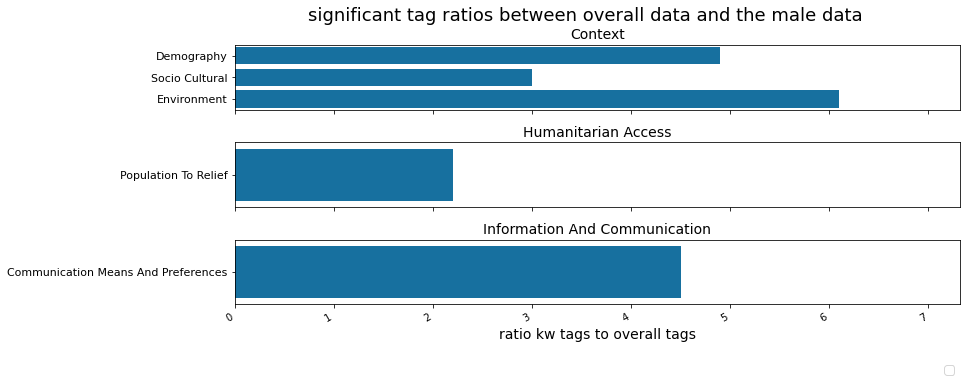

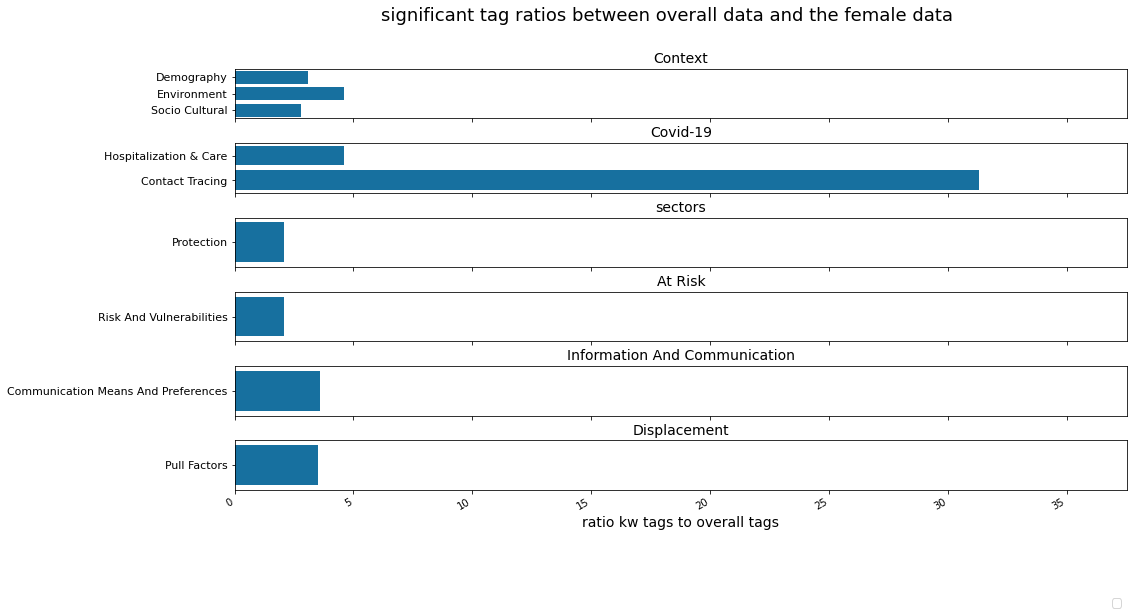

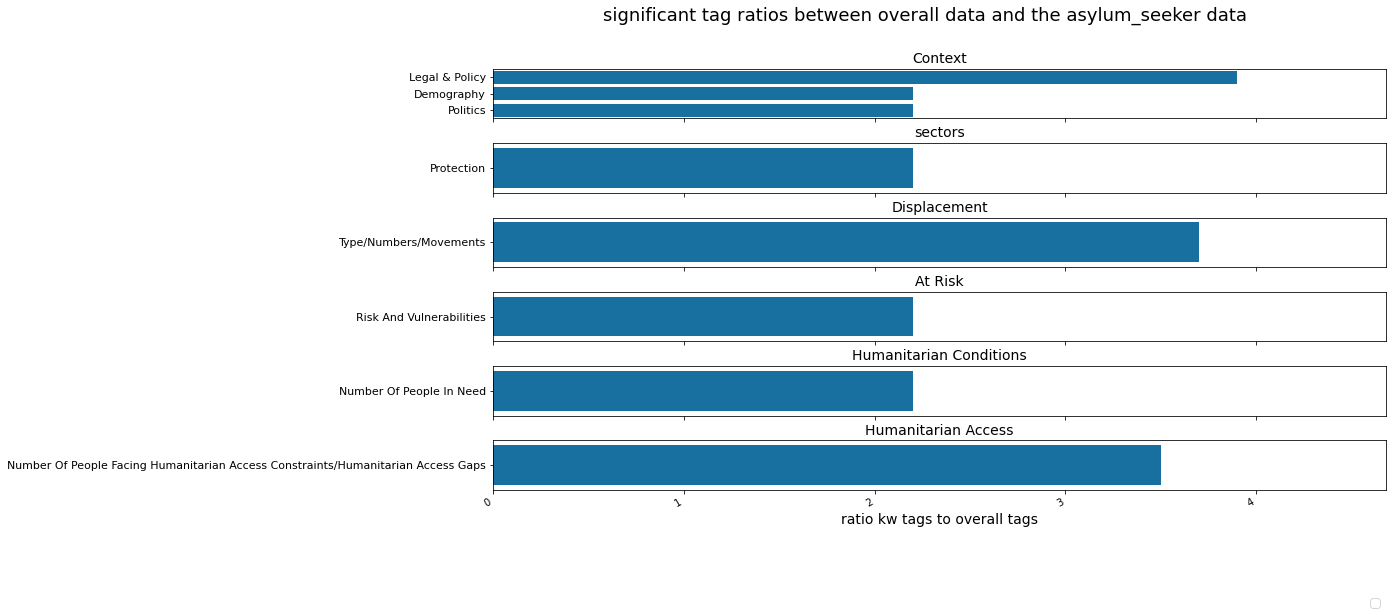

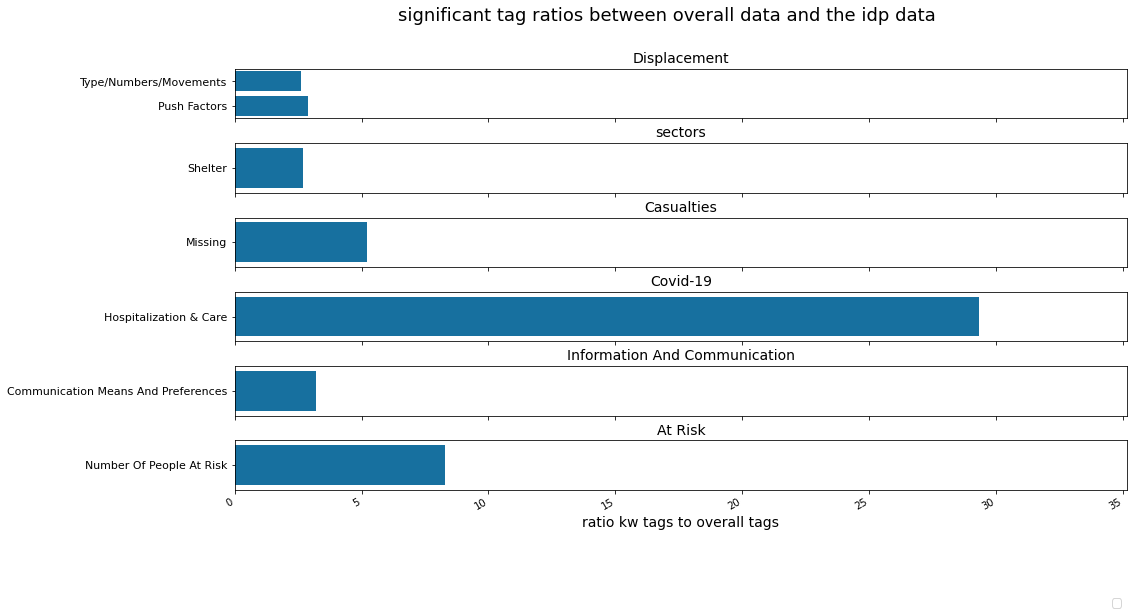

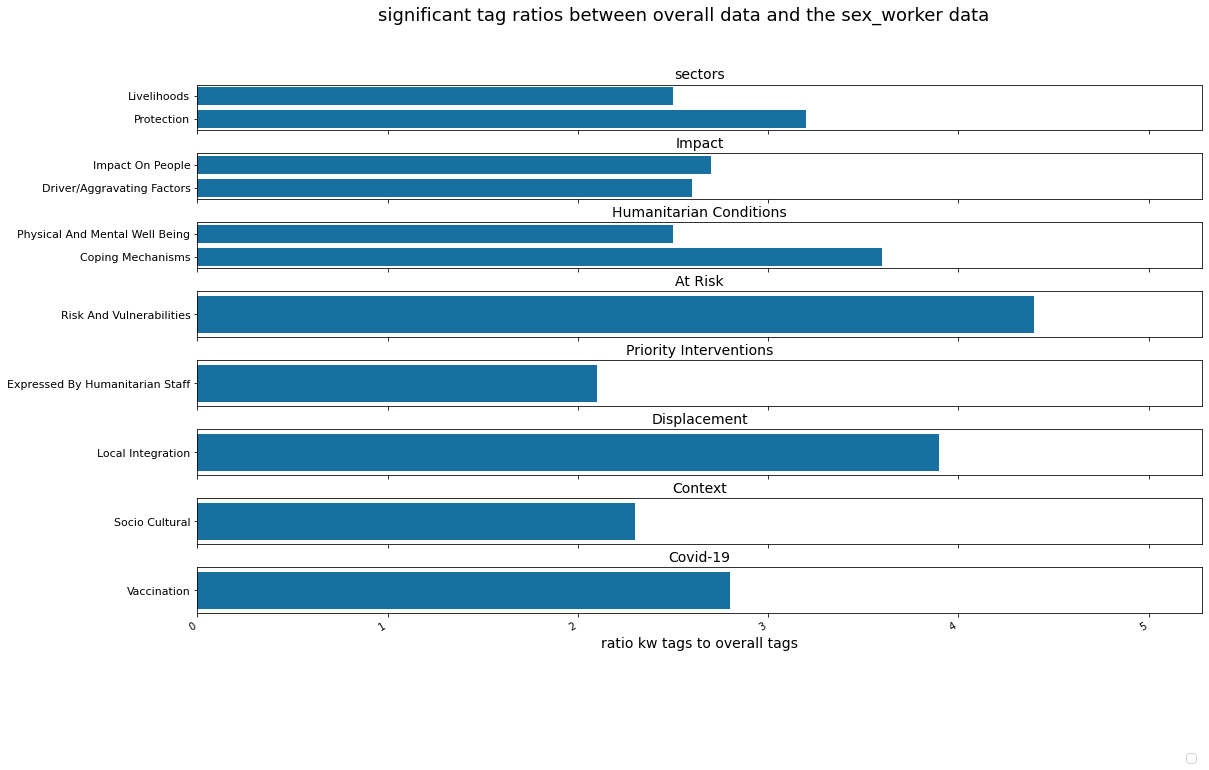

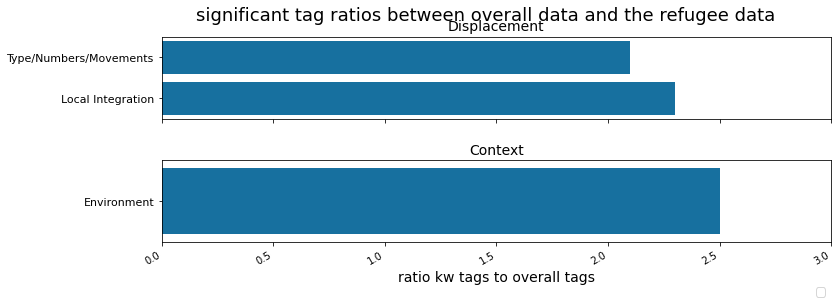

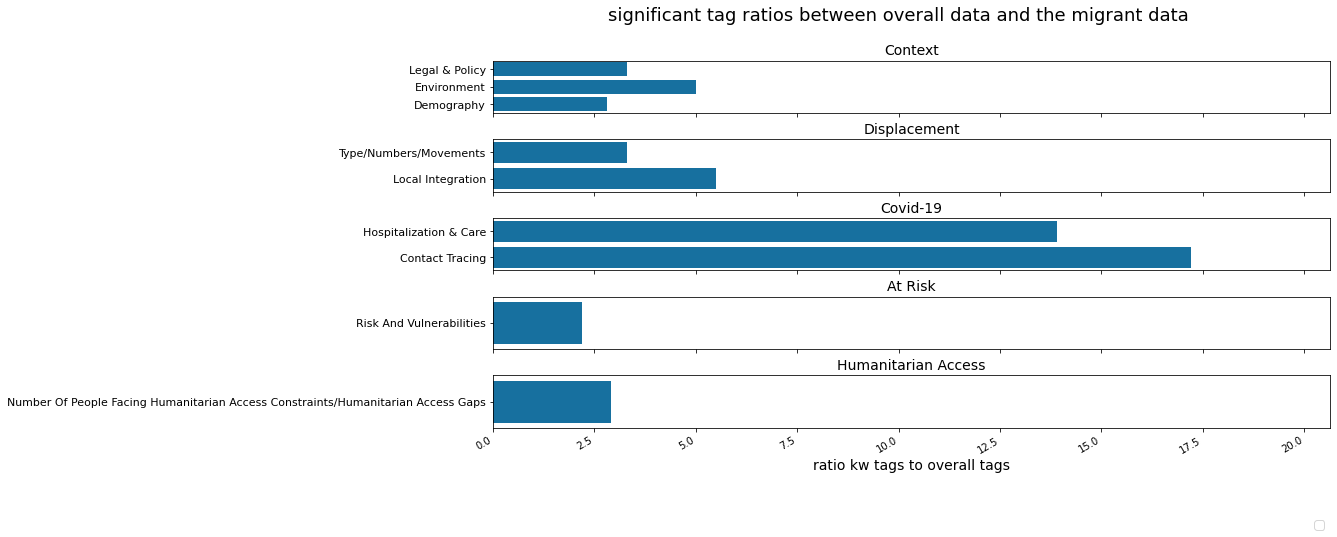

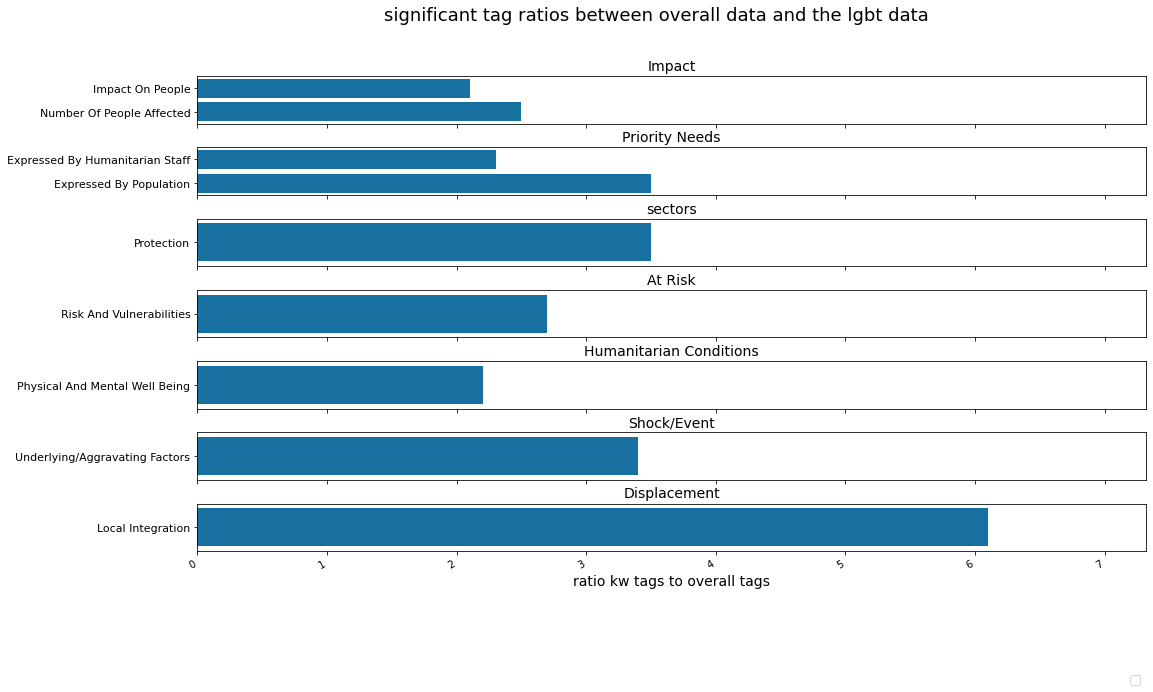

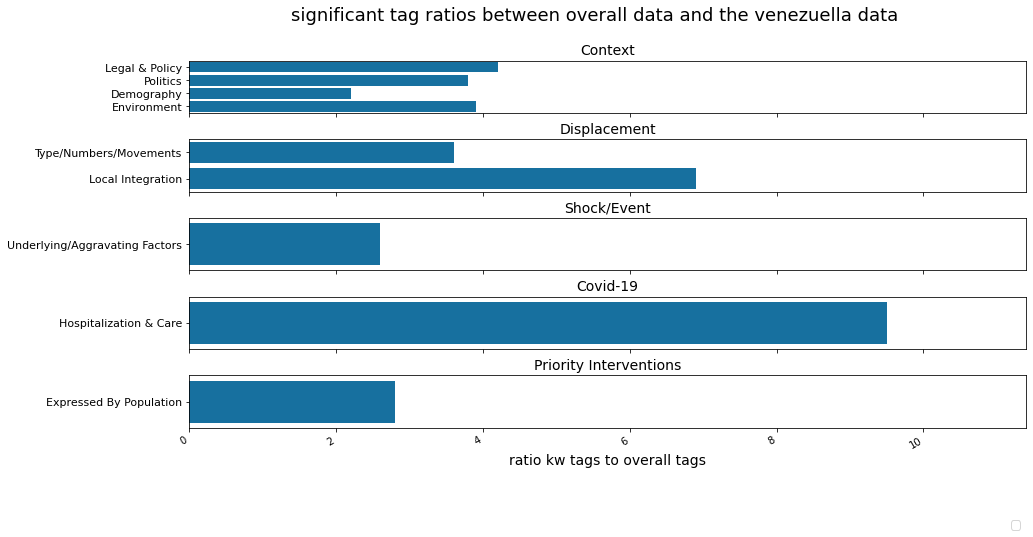

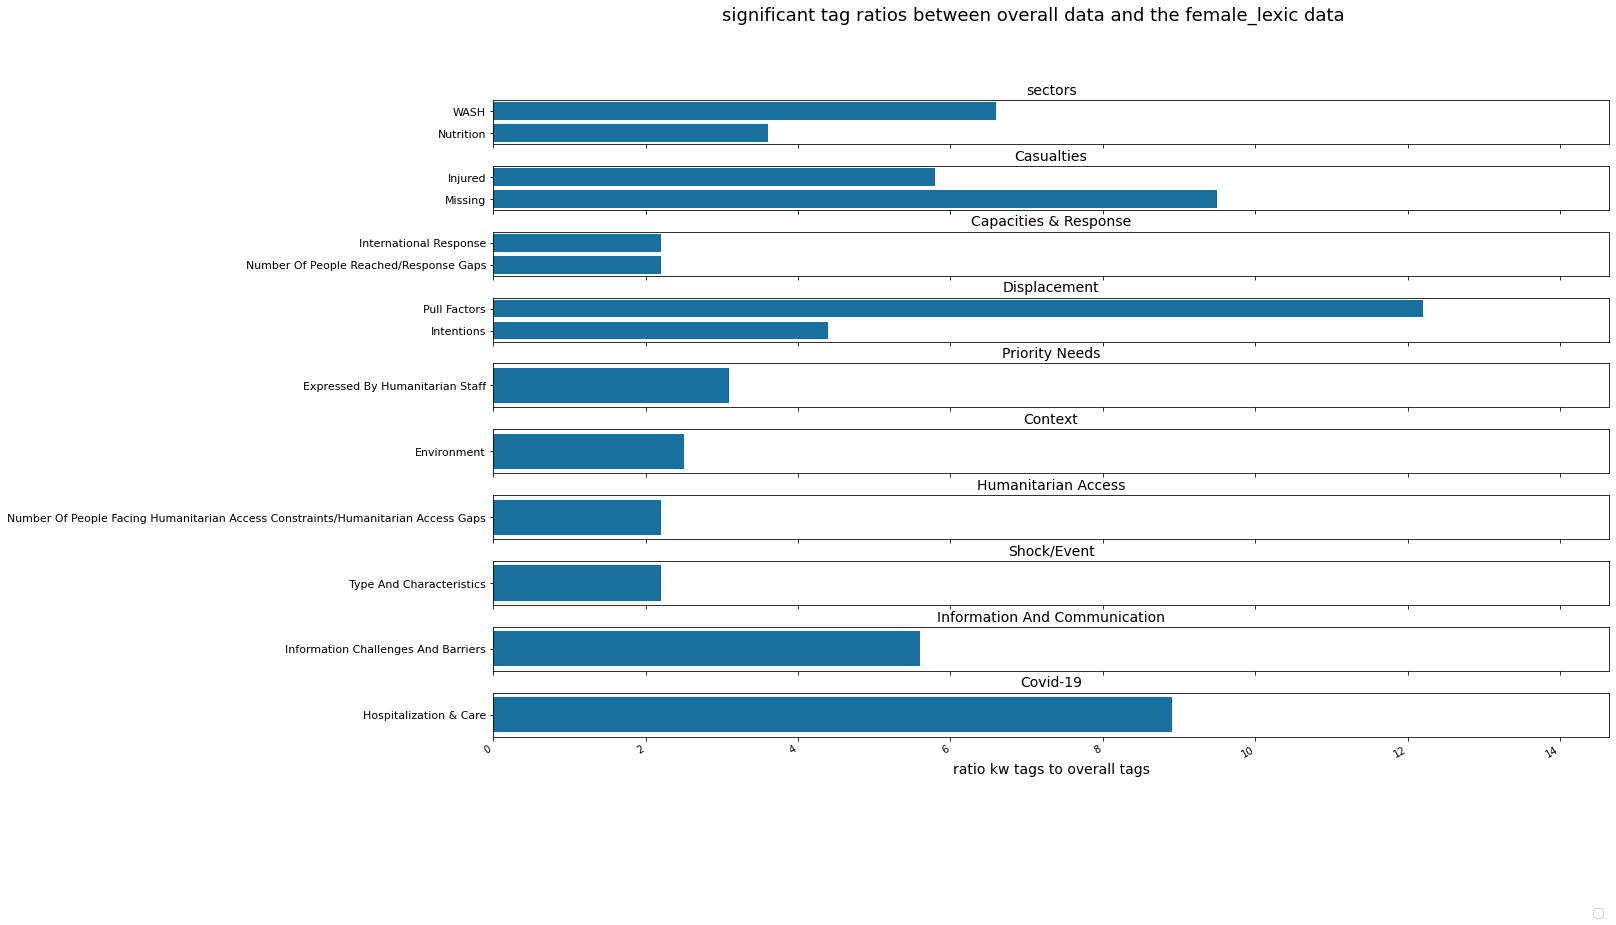

In [17]:
for col in kw_columns:
    get_vizu_2_lvl(kw_targets[col], max_ratio=2, image_name=col.replace('_kw', ''))

In [13]:
def get_wordcloud(text: str, fig_name: str = None):
    """
    from https://github.com/amueller/word_cloud/blob/master/examples/simple.py
    """
    # Generate a word cloud image
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

    plt.savefig(f'EDA/wordcloud/{fig_name}')
    """# lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")"""
    plt.show()

male_kw


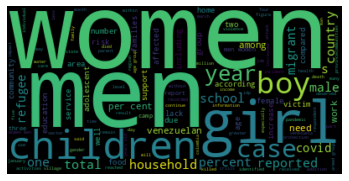

female_kw


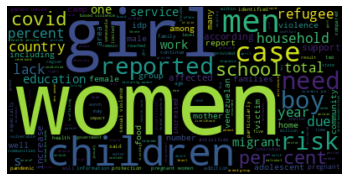

asylum_seeker_kw


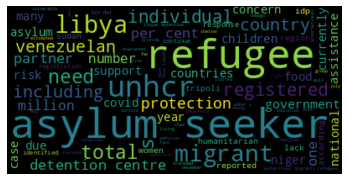

idp_kw


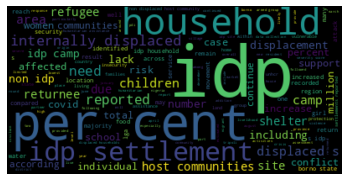

sex_worker_kw


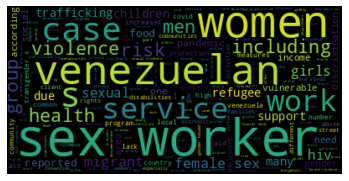

refugee_kw


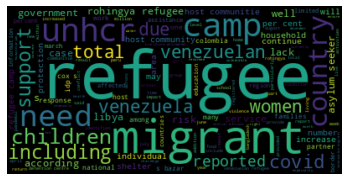

migrant_kw


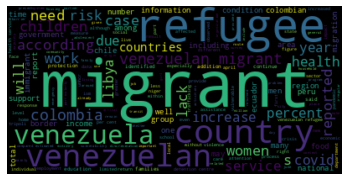

lgbt_kw


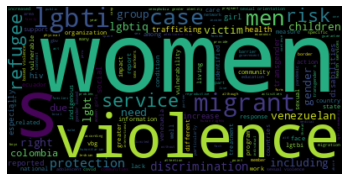

venezuella_kw


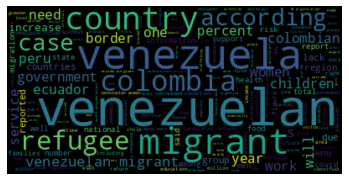

female_lexic_kw


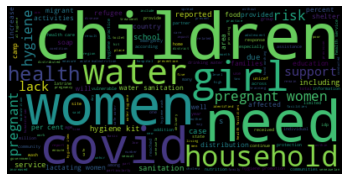

In [14]:
for col in kw_columns:
    print(col)
    one_kw_excerpts = (
        " ".join(df[df[col].apply(lambda x: len(x) > 0)].excerpt.tolist())
        .lower()
        .replace("people", "")
        .replace("access", "")
        .replace("person", "")
        .replace("population", "")
        .replace("situation", "")
    )

    get_wordcloud(one_kw_excerpts, col.replace('_kw', ''))